In [6]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import optax
import distrax

import tensorflow as tf
import tensorflow_datasets as tfds

Array = jnp.ndarray
PRNGKey = Array

def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)
    
    n_n = distrax.Independent(
          distrax.MultivariateNormalDiag(mu_noise, sigma_noise)).sample(
              seed=keys[0],
              sample_shape=[len(d),
                            len(priors)])
    
    # sample random gamma noise
    n_g = distrax.Gamma(2., 1./2.).sample(seed=keys[1], 
                                          sample_shape=[len(d),
                                                        len(priors)
                                                        ]
                                          )
    
    # perform forward pass
    y = jnp.broadcast_to(priors[:,0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:,1], 0) 
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:,1]

    return y, ygrads

In [2]:
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.,0., 5., 10.])
d = jnp.array([1.])
num_samples = 100


def prep_data(d: Array, priors: Array, key: PRNGKey):
  'Returns data in a format suitable for normalizing flow training.'
  keys = jrandom.split(key, 2)
  
  theta_shape = (2,)

  mu = jnp.zeros(theta_shape)
  sigma = (3 ** 2) * jnp.ones(theta_shape) 

  base_distribution = distrax.Independent( # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma))

  priors = base_distribution.sample(seed=keys[0], sample_shape=[len(d), 
                                                            num_samples])
  
  y = sim_linear_jax(d, priors, keys[1])

  return jnp.column_stack( (y[0].T, jnp.squeeze(priors)) )

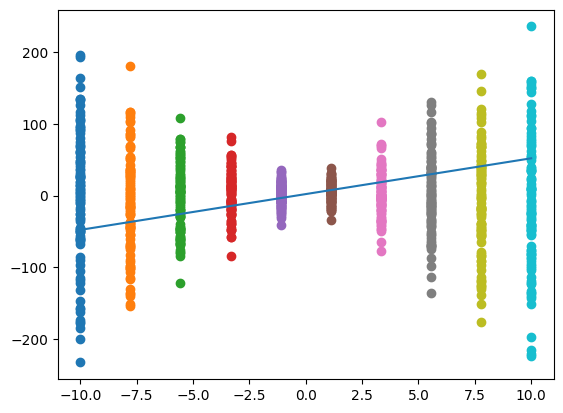

In [3]:
import matplotlib.pyplot as plt

num_samples = 100 # Probs enough

x = jnp.linspace(-10., 10., num=10)
y = 2. + 5. * x  

theta_shape = (2,)

mu = jnp.zeros(theta_shape)
sigma = (3 ** 2) * jnp.ones(theta_shape) 

base_distribution = distrax.Independent( # Should this be independent?
      distrax.MultivariateNormalDiag(mu, sigma))

priors = base_distribution.sample(seed=key, sample_shape=[len(x), 
                                                          num_samples])
y_pred = sim_linear_jax(x, priors, key)
# data =prep_data(x, num_samples, key)

# Get the stddevs of the priors to plot fill between
y_std = jnp.mean(y_pred[0], axis=1)

# Plotting
fig, ax = plt.subplots()

ax.plot(x, y)
for i, val in enumerate(y_pred[0]):
  ax.scatter([x[i]] * 100, val)

In [1]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import numpy as np
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from distrax._src.bijectors import bijector as bjct_base
from distrax._src.bijectors.masked_coupling import MaskedCoupling
from distrax._src.bijectors.inverse import Inverse
from distrax._src.bijectors.chain import Chain
from distrax._src.bijectors.scalar_affine import ScalarAffine
from distrax._src.bijectors.block import Block

from distrax._src.distributions import distribution as dist_base
from distrax._src.distributions.transformed import Transformed
from distrax._src.utils import conversion, math

from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple, Callable, Union


Array = dist_base.Array
DistributionLike = dist_base.DistributionLike
BijectorLike = bjct_base.BijectorLike

Array = bjct_base.Array
BijectorParams = Any

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)
    
    n_n = distrax.Independent(
          distrax.MultivariateNormalDiag(mu_noise, sigma_noise)).sample(
              seed=keys[0],
              sample_shape=[len(d),
                            len(priors)])
    
    # sample random gamma noise
    n_g = distrax.Gamma(2., 1./2.).sample(seed=keys[1], 
                                          sample_shape=[len(d),
                                                        len(priors)
                                                        ]
                                          )
    
    # perform forward pass
    y = jnp.broadcast_to(priors[:,0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:,1], 0) 
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:,1]

    return y, ygrads

def prep_data(d: Array, priors: Array, key: PRNGKey):
  '''
  Returns data in a format suitable for normalizing flow training.
  Data will be in shape [y, thetas]. The `y` variable can vary in size.
  '''
  keys = jrandom.split(key, 2)
  
  theta_shape = (2,)

  mu = jnp.zeros(theta_shape)
  sigma = (3 ** 2) * jnp.ones(theta_shape) 

  base_distribution = distrax.Independent( # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma))

  priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])
  
  y, _ = sim_linear_jax(d, priors, keys[1])
  
  return jnp.column_stack( (y.T, jnp.squeeze(priors)) )


class MaskedConditionalCoupling(MaskedCoupling):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    
  def forward_and_log_det(self, x: Array, z: Array) -> Tuple[Array, Array]:
    """Computes y = f(x|z) and log|det J(f)(x|z)|."""
    self._check_forward_input_shape(x)
    masked_x = jnp.where(self._event_mask, x, 0.)
    # TODO: Better logic to detect when scalar x
    if masked_x.shape[1] == 1:
        params = self._conditioner(z)
    else:
        params = self._conditioner(masked_x, z)
    y0, log_d = self._inner_bijector(params).forward_and_log_det(x)
    y = jnp.where(self._event_mask, x, y0)
    logdet = math.sum_last(
        jnp.where(self._mask, 0., log_d),
        self._event_ndims - self._inner_event_ndims)
    return y, logdet

  def inverse_and_log_det(self, y: Array, z: Array) -> Tuple[Array, Array]:
    """Computes x = f^{-1}(y|z) and log|det J(f^{-1})(y|z)|."""
    self._check_inverse_input_shape(y)
    masked_y = jnp.where(self._event_mask, y, 0.)
    # params = self._conditioner(masked_y, z)
    z = jnp.squeeze(z)
    params = self._conditioner(z)
    x0, log_d = self._inner_bijector(params).inverse_and_log_det(y)
    x = jnp.where(self._event_mask, y, x0)
    logdet = math.sum_last(jnp.where(self._mask, 0., log_d),
                           self._event_ndims - self._inner_event_ndims)
    return x, logdet


class StandardizingBijector(ScalarAffine):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x: Array, z: Array) -> Array:
    """Computes y = f(x)."""
    batch_shape = jax.lax.broadcast_shapes(self._batch_shape, x.shape)
    batched_scale = jnp.broadcast_to(self._scale, batch_shape)
    batched_shift = jnp.broadcast_to(self._shift, batch_shape)
    return batched_scale * x + batched_shift

  def forward_log_det_jacobian(self, x: Array, z: Array) -> Array:
    """Computes log|det J(f)(x)|."""
    batch_shape = jax.lax.broadcast_shapes(self._batch_shape, x.shape)
    return jnp.broadcast_to(self._log_scale, batch_shape)

  def forward_and_log_det(self, x: Array, z: Array) -> Tuple[Array, Array]:
    """Computes y = f(x) and log|det J(f)(x)|."""
    return self.forward(x, z), self.forward_log_det_jacobian(x, z)

  def inverse(self, y: Array, z: Array) -> Array:
    """Computes x = f^{-1}(y)."""
    batch_shape = jax.lax.broadcast_shapes(self._batch_shape, y.shape)
    batched_inv_scale = jnp.broadcast_to(self._inv_scale, batch_shape)
    batched_shift = jnp.broadcast_to(self._shift, batch_shape)
    return batched_inv_scale * (y - batched_shift)

  def inverse_log_det_jacobian(self, y: Array, z: Array) -> Array:
    """Computes log|det J(f^{-1})(y)|."""
    batch_shape = jax.lax.broadcast_shapes(self._batch_shape, y.shape)
    return jnp.broadcast_to(jnp.negative(self._log_scale), batch_shape)

  def inverse_and_log_det(self, y: Array, z: Array) -> Tuple[Array, Array]:
    """Computes x = f^{-1}(y) and log|det J(f^{-1})(y)|."""
    return self.inverse(y, z), self.inverse_log_det_jacobian(y, z)


class ConditionalBlock(Block):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x: Array, z: Array) -> Array:
    """Computes y = f(x)."""
    self._check_forward_input_shape(x)
    return self._bijector.forward(x, z)

  def inverse(self, y: Array, z: Array) -> Array:
    """Computes x = f^{-1}(y)."""
    self._check_inverse_input_shape(y)
    return self._bijector.inverse(y, z)

  def forward_log_det_jacobian(self, x: Array, z: Array) -> Array:
    """Computes log|det J(f)(x)|."""
    self._check_forward_input_shape(x)
    log_det = self._bijector.forward_log_det_jacobian(x, z)
    return math.sum_last(log_det, self._ndims)

  def inverse_log_det_jacobian(self, y: Array, z: Array) -> Array:
    """Computes log|det J(f^{-1})(y)|."""
    self._check_inverse_input_shape(y)
    log_det = self._bijector.inverse_log_det_jacobian(y, z)
    return math.sum_last(log_det, self._ndims)

  def forward_and_log_det(self, x: Array, z: Array) -> Tuple[Array, Array]:
    """Computes y = f(x) and log|det J(f)(x)|."""
    self._check_forward_input_shape(x)
    y, log_det = self._bijector.forward_and_log_det(x, z)
    return y, math.sum_last(log_det, self._ndims)

  def inverse_and_log_det(self, y: Array, z: Array) -> Tuple[Array, Array]:
    """Computes x = f^{-1}(y) and log|det J(f^{-1})(y)|."""
    self._check_inverse_input_shape(y)
    x, log_det = self._bijector.inverse_and_log_det(y, z)
    return x, math.sum_last(log_det, self._ndims)


class ConditionalInverse(Inverse):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x: Array, z: Array) -> Array:
    """Computes y = f(x)."""
    return self._bijector.inverse(x, z)

  def inverse(self, y: Array, z: Array) -> Array:
    """Computes x = f^{-1}(y)."""
    return self._bijector.forward(y, z)
  
  def forward_and_log_det(self, x: Array, z: Array) -> Tuple[Array, Array]:
    """Computes y = f(x|z) and log|det J(f)(x|z)|."""
    return self._bijector.inverse_and_log_det(x, z)

  def inverse_and_log_det(self, y: Array, z: Array) -> Tuple[Array, Array]:
    """Computes x = f^{-1}(y) and log|det J(f^{-1})(y)|."""
    return self._bijector.forward_and_log_det(y, z)


class ConditionalChain(Chain):
  def __init__(self, *args):
    super().__init__(*args)

  def forward(self, x: Array, z: Array) -> Array:
    """Computes y = f(x)."""
    for bijector in reversed(self._bijectors):
      x = bijector.forward(x, z)
    return x

  def inverse(self, y: Array, z: Array) -> Array:
    """Computes x = f^{-1}(y)."""
    for bijector in self._bijectors:
      y = bijector.inverse(y, z)
    return y
  
  def forward_and_log_det(self, x: Array, z: Array) -> Tuple[Array, Array]:
    """Computes y = f(x) and log|det J(f)(x)|."""
    x, log_det = self._bijectors[-1].forward_and_log_det(x, z)
    for bijector in reversed(self._bijectors[:-1]):
      x, ld = bijector.forward_and_log_det(x, z)
      log_det += ld
    return x, log_det

  def inverse_and_log_det(self, y: Array, z: Array) -> Tuple[Array, Array]:
    """Computes x = f^{-1}(y) and log|det J(f^{-1})(y)|."""
    y, log_det = self._bijectors[0].inverse_and_log_det(y, z)
    for bijector in self._bijectors[1:]:
      y, ld = bijector.inverse_and_log_det(y, z)
      log_det += ld
    return y, log_det


class ConditionalTransformed(Transformed):
  def __init__(self, distribution, flow):
    super().__init__(distribution, flow)

  def _sample_n(self, key: PRNGKey, n: int, z: Array) -> Array:
    """Returns `n` samples conditioned on `z`."""
    x = self.distribution.sample(seed=key, sample_shape=n)
    y, _ = self.bijector.forward_and_log_det(x, z)
    return y

  def log_prob(self, value: Array, z: Array) -> Array:
    """See `Distribution.log_prob`."""
    x, ildj_y = self.bijector.inverse_and_log_det(value, z)
    lp_x = self.distribution.log_prob(x)
    lp_y = lp_x + ildj_y
    return lp_y

  def _sample_n_and_log_prob(self, key: PRNGKey, n: int, z: Array) -> Tuple[Array, Array]:
    """Returns `n` samples and their log probs depending on `z`.

    This function is more efficient than calling `sample` and `log_prob`
    separately, because it uses only the forward methods of the bijector. It
    also works for bijectors that don't implement inverse methods.

    Args:
      key: PRNG key.
      n: Number of samples to generate.

    Returns:
      A tuple of `n` samples and their log probs.
    """
    x, lp_x = self.distribution.sample_and_log_prob(seed=key, sample_shape=n)
    y, fldj = jax.vmap(self.bijector.forward_and_log_det)(x, z)
    lp_y = jax.vmap(jnp.subtract)(lp_x, fldj)
    return y, lp_y

# ---------------------
# Making the flow model
# --------------------- 
def make_conditioner2(event_shape: Sequence[int],
                     cond_info_shape: Sequence[int],
                     hidden_sizes: Sequence[int],
                     num_bijector_params: int) -> hk.Module: # Is this correct?
  class ConditionerModule(hk.Module):
    def __call__(self, x, z):
      # Normalize the theta values
      z = (z - z.mean(axis=0)) / (z.std(axis=0) + 1e-14)
      x = hk.Flatten(preserve_dims=-len(event_shape))(x)
      z = hk.Flatten(preserve_dims=-len(cond_info_shape))(z)
      x = jnp.concatenate((x, z), axis=1)
      x = hk.nets.MLP(hidden_sizes, activate_final=True)(x)
      x = hk.Linear(
          np.prod(event_shape) * num_bijector_params,
          w_init=jnp.zeros,
          b_init=jnp.zeros)(x)
      x = hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1)(x)
      return x
  return ConditionerModule()


def scalar_conditioner(event_shape: Sequence[int],
                      cond_info_shape: Sequence[int],
                      hidden_sizes: Sequence[int],
                      num_bijector_params: int) -> hk.Module: # Is this correct?
  class ConditionerModule(hk.Module):
    def __call__(self, x):
      # thetas = (thetas - thetas.mean(axis=0)) / thetas.std(axis=0)
      x = (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-14)
      x = hk.Flatten(preserve_dims=-len(cond_info_shape))(x)
      x = hk.nets.MLP(hidden_sizes, activate_final=True)(x)
      x = hk.Linear(
          np.prod(event_shape) * num_bijector_params, # This event_shape can be an int or tuple
          w_init=jnp.zeros,
          b_init=jnp.zeros)(x)
      # This reshape function is important for getting parameters in place for
      # subsequent evaluation by the _inner_bijector.
      
      x = hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1)(x)
      # This ^ event_shape must be a tuple...
    #   x = hk.Reshape(tuple(3) + (num_bijector_params,), preserve_dims=-1)(x)
      return x
  return ConditionerModule()


def make_flow_model(event_shape: Sequence[int],
                    cond_info_shape: Sequence[int],
                    num_layers: int,
                    hidden_sizes: Sequence[int],
                    num_bins: int,
                    shift: float,
                    scale: float,) -> distrax.Transformed:
  """Creates the flow model."""
  # Alternating binary mask.
  mask = jnp.arange(0, np.prod(event_shape)) % 2
  mask = jnp.reshape(mask, event_shape)
  mask = mask.astype(bool)
  if event_shape == (1,):
    mask = jnp.array([1]).astype(bool)

  def bijector_fn(params: Array):
    return distrax.RationalQuadraticSpline(
        params, range_min=0., range_max=1.)

  # Number of parameters for the rational-quadratic spline:
  # - `num_bins` bin widths
  # - `num_bins` bin heights
  # - `num_bins + 1` knot slopes``
  # for a total of `3 * num_bins + 1` parameters.
  num_bijector_params = 3 * num_bins + 1

  # Starting with a standardizing layer - might want to put at end
  layers = [
      # ConditionalInverse(ConditionalBlock(StandardizingBijector(shift, scale), event_shape[0]))
      ConditionalInverse(ConditionalBlock(StandardizingBijector(shift, scale), 1))
  ]
  
  if event_shape == (1,):
    conditioner = scalar_conditioner(event_shape,
                                      cond_info_shape,
                                      hidden_sizes,
                                      num_bijector_params)
  else:
    conditioner = make_conditioner2(event_shape,
                                      cond_info_shape,
                                      hidden_sizes,
                                      num_bijector_params)

  # Append subsequent layers
  for _ in range(num_layers):
    # Could use better logic on what type of conditioner to make based on event_shape.
    layer = MaskedConditionalCoupling(
        mask=mask,
        bijector=bijector_fn,
        conditioner=conditioner,)
        # event_ndims=event_shape[0])
    layers.append(layer)
    # Flip the mask after each layer.
    if event_shape != (1,):
        mask = jnp.logical_not(mask)
  
  # We invert the flow so that the `forward` method is called with `log_prob`.
  # flow = distrax.Inverse(distrax.Chain(layers))
  # **** Error occurs here when making the flow ****
  flow = ConditionalInverse(ConditionalChain(layers))
  
  # Making base a Gaussian.
  mu = jnp.zeros(event_shape)
  sigma = jnp.ones(event_shape)
  # For scalar, doesn't matter if Independent is used but maybe will for 2D+
  base_distribution = distrax.Independent(
      distrax.MultivariateNormalDiag(mu, sigma))
  # base_distribution = distrax.MultivariateNormalDiag(mu, sigma)
  
  # return distrax.Transformed(base_distribution, flow)
  return ConditionalTransformed(base_distribution, flow)


# ----------------------------------------
# Helper functions to simulate data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
  ds = split
  ds = ds.shuffle(buffer_size=10 * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=1000)
  ds = ds.repeat()
  return iter(tfds.as_numpy(ds))


def prep_data(d: Array, priors: Array, key: PRNGKey):
  '''
  Returns data in a format suitable for normalizing flow training.
  Data will be in shape [y, thetas]. The `y` variable can vary in size.
  '''
  keys = jrandom.split(key, 2)
  
  theta_shape = (2,)

  mu = jnp.zeros(theta_shape)
  sigma = (3 ** 2) * jnp.ones(theta_shape) 

  base_distribution = distrax.Independent( # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma))

  priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])
  
  y, ygrads = sim_linear_jax(d, priors, keys[1])
  
  return jnp.column_stack( (y.T, jnp.squeeze(priors)) )


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
  data = batch.astype(np.float32)
  # Handling the scalar case
  if data.shape[1] <= 3:
      x = jnp.expand_dims(data[:, :-2], -1)
  x = data[:, :-2]
  thetas = data[:, -2:]
  # thetas = (thetas - thetas.mean(axis=0)) / thetas.std(axis=0)
  return x, thetas

# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, cond_data: Array) -> Array:
  # Get batch 
  shift = data.mean(axis=0)
  scale = data.std(axis=0) + 1e-14
  # jax.debug.print("{scale}", scale=scale)
  # jax.debug.print("{shift}", shift=shift)
  
  model = make_flow_model(
      event_shape=EVENT_SHAPE,
      cond_info_shape=cond_info_shape,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins,
      shift=shift,
      scale=scale)
  return model.log_prob(data, cond_data)

@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
  model = make_flow_model(
      event_shape=EVENT_SHAPE,
      cond_info_shape=cond_info_shape,
      num_layers=flow_num_layers,
      hidden_sizes=[hidden_size] * mlp_num_layers,
      num_bins=num_bins)
  z = jnp.repeat(cond_data, num_samples, axis=0)
  z = jnp.expand_dims(z, -1)
  return model._sample_n(key=key, 
                         n=[num_samples],
                         z=z)

def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
  x, thetas = prepare_data(batch, prng_key)
  # Loss is average negative log likelihood.
  loss = -jnp.mean(log_prob.apply(params, x, thetas))
  return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
  x, thetas = prepare_data(batch) 
  loss = -jnp.mean(log_prob.apply(params, x, thetas))
  return loss


@jax.jit
def update(params: hk.Params,
            prng_key: PRNGKey,
            opt_state: OptState,
            batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single SGD update step."""
  grads = jax.grad(loss_fn)(params, prng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [4]:
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.,0., 5., 10.])
# d = jnp.array([1., 2.])
d = jnp.array([1.])
num_samples = 100

# Params and hyperparams
theta_shape = (2,)
EVENT_SHAPE = (len(d),) 
cond_info_shape = theta_shape

batch_size = 128
flow_num_layers = 10
mlp_num_layers = 4
hidden_size = 500
num_bins = 4
learning_rate = 1e-4

# using 100,000 steps could take long (about 2 hours) but will give better results. 
# You can try with 10,000 steps to run it fast but result may not be very good

training_steps =  10#00
eval_frequency =  1

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
X = prep_data(d, num_samples, key)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(next(prng_seq), 
                    np.zeros((1, *EVENT_SHAPE)), 
                    np.zeros((1, *cond_info_shape)))
opt_state = optimizer.init(params)


for step in range(training_steps):
    params, opt_state = update(params, next(prng_seq), opt_state,
                                next(train_ds))

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")

/Users/vincent_zaballa/anaconda3/envs/sbidoeman2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:1923: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


STEP:     0; Validation loss: 4.011
STEP:     1; Validation loss: 4.029
STEP:     2; Validation loss: 4.003
STEP:     3; Validation loss: 4.005
STEP:     4; Validation loss: 3.991
STEP:     5; Validation loss: 3.988
STEP:     6; Validation loss: 4.024
STEP:     7; Validation loss: 4.045
STEP:     8; Validation loss: 4.008
STEP:     9; Validation loss: 4.081


In [3]:
# Adding promisys and some simualator
import sbidoeman
# from sbidoeman.main import sbidoe, sbidoe_bma
from sbidoeman.simulator import bmp_simulator